# Train a model for the mass as a function of z, hmag, color

- Use UltraVISTA (which has pretty well defined masses) to calibrate the model.
- Apply the model to 3D-HST to evaluate how well it does.

In [1]:
from grizli import utils
import matplotlib.pyplot as plt
import eazy.utils
import numpy as np
from scipy import interpolate

from astropy.modeling import fitting, models

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from astropy.table import vstack, Table
import os

## Load 3D-HST catalogs (with F160W, F814W, lmass, photo-z)
Goods-N does not have F814W. Here, I rename F775W as F814W for simplicity in color computation. Don't forget you did that!

In [2]:
field='goodss'
version = 'v4.1'
cat = utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version))

cats = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version)) for field in ['aegis','cosmos','goodsn','goodss','uds']]
cat = vstack(cats)
cat['cat'] = '3dhst'

zouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.zout'.format(field, version)) for field in ['aegis','cosmos','goodsn','goodss','uds']]
zout = vstack(zouts)

fouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Fast/{0}_3dhst.{1}.fout'.format(field, version)) for field in ['aegis','cosmos','goodsn','goodss','uds']]
fout = vstack(fouts)

colors = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/RF_colors/{0}_3dhst.{1}.master.RF'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
color = vstack(colors)

color['u-v'] = -2.5*np.log10(color['L153']/color['L155'])
color['v-j'] = -2.5*np.log10(color['L155']/color['L161'])


In [77]:
sf = np.ones(len(color)).astype('bool')

for i,row in enumerate(color):
    if (row['v-j']<=1.6) & (row['v-j']>0.81):
        lim = 0.88*row['v-j']+0.59
        if row['u-v'] > lim:
            sf[i] = False
    elif (row['v-j'] <= 0.81):
        if row['u-v'] > 1.3:
            sf[i] = False


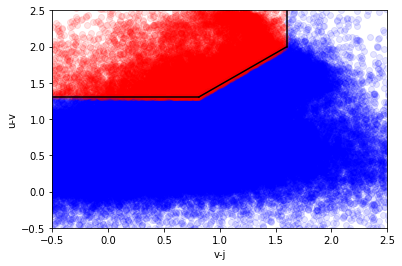

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(color['v-j'][sf],color['u-v'][sf],alpha=0.1,c='b')
ax.scatter(color['v-j'][~sf],color['u-v'][~sf],alpha=0.1,c='r')
ax.set_ylim([-0.5,2.5])
ax.set_xlim([-0.5,2.5])
x1 = np.linspace(-0.5,0.81)
y1 = 1.3*np.ones(len(x1))
x2 = np.linspace(0.81,1.6)
y2 = 0.88*x2+0.59
y3 = np.linspace(2,2.5)
x3 = 1.6*np.ones(len(y3))
ax.plot(x1,y1,c='k')
ax.plot(x2,y2,c='k')
ax.plot(x3,y3,c='k')
ax.set_xlabel('v-j')
ax.set_ylabel('u-v')
plt.show()

In [79]:
len(sf),sf.sum()

(207967, 191701)

## Trian on 3dhst

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.057618e-19
  overwrite_a=True).T


../figures/3dhst_mass_f_F140W_f_F125W-f_F160W_d753_z1.0.png
../model_uvista_interp/3dhst_mass_f_F140W_f_F125W-f_F160W_d753_z1.0.npy


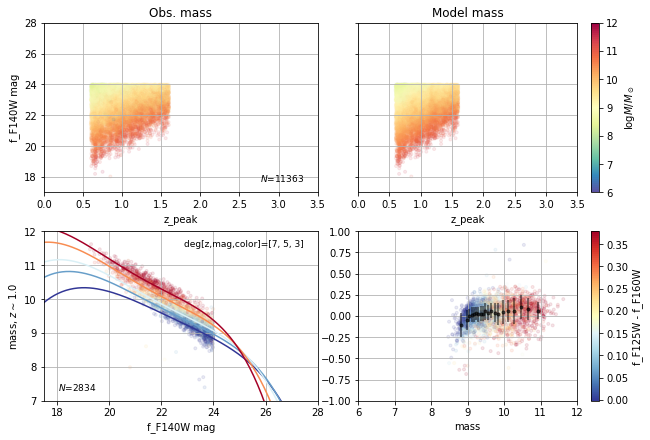

In [7]:
uphot_bands = ['f_F125W', 'f_F160W']
umag_band = 'f_F140W'
zshow = 1.

degree = [7,5,3]

#clf = linear_model.LinearRegression()

# Use Ridge regressor to constrain high-order parameters and improve
# extrapolation
ridge_alpha = 0.01
clf = linear_model.Ridge(alpha=ridge_alpha)
out = empirical_mass2(cat, zout, fout, mag_band=umag_band, mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='3dhst')

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in maximum
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


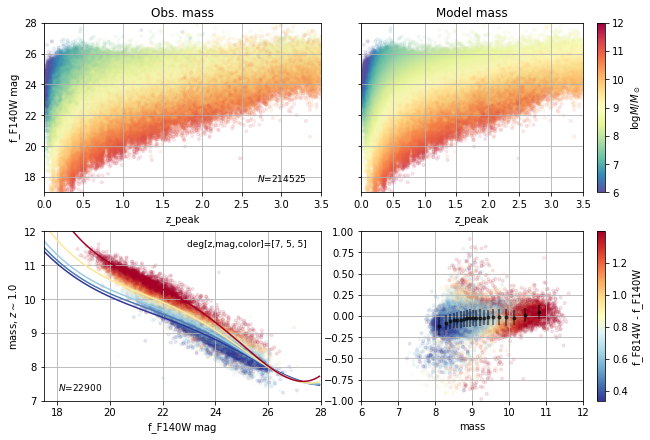

In [50]:
uvista_fit = np.load('../scratch/3dhst_mass_f_F140W_f_F814W-f_F140W_d755_z1.0.npy')
phot_bands = ['f_F814W', 'f_F140W']
mag_band = 'f_F140W'
dq = (ucat['contamination'] == 0) & (ucat['star'] == 0) & (ucat['nan_contam'] == 0)

mag_ZP=25
root='predict-uvista'
static_fit=uvista_fit
dq = None
xx = empirical_mass2(ucat, uzout, ufout, mag_band=mag_band, mag_ZP=25, phot_bands=phot_bands, degree=degree, clf=clf, zshow=zshow, root='predict-3dhst', static_fit=uvista_fit)

## Train on UltraVISTA
- using H-band and iHSC

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in maximum
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.288990e-23
  overwrite_a=True).T
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


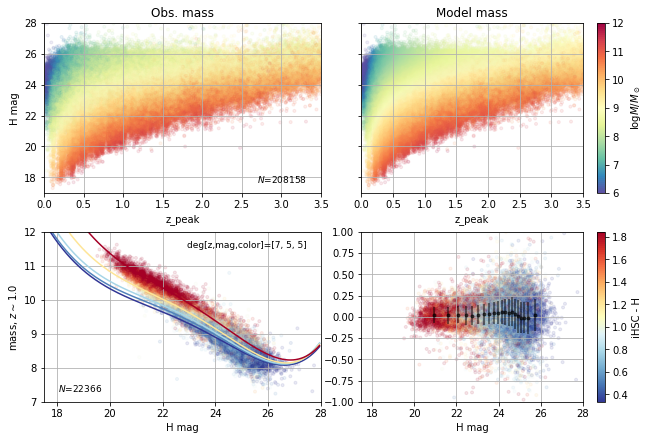

In [5]:
##############
# Train on UltraVISTA ground-based catalog, huge area better sampling 
# at high masses, though not as good at faint end

# Read catalogs
ucat = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.cat')
uzout = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.zout')
ufout = Table(np.genfromtxt('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.fout'),names = ('0','1','2','3','4','5','lmass','7','8','9','10'))
ucat['cat']='uvista'

#dq = (ucat['contamination'] == 0) & (ucat['star'] == 0) & (ucat['nan_contam'] == 0)
uphot_bands = ['iHSC', 'H']
umag_band = 'H'
zshow = 1.0

degree = [7,5,5]

#clf = linear_model.LinearRegression()

# Use Ridge regressor to constrain high-order parameters and improve
# extrapolation
ridge_alpha = 0.01
clf = linear_model.Ridge(alpha=ridge_alpha)
out = empirical_mass(ucat, uzout, ufout, mag_band=umag_band, mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='uvista')

## Train on UltraVISTA - interpolated phot
- using interpolated F160W and F814W
- mass from original catalog (not the interpolated one)

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in maximum
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.706207e-22
  overwrite_a=True).T
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


../figures/uvista_mass_f_F140W_f_F125W-f_F160W_d755_z1.0.png


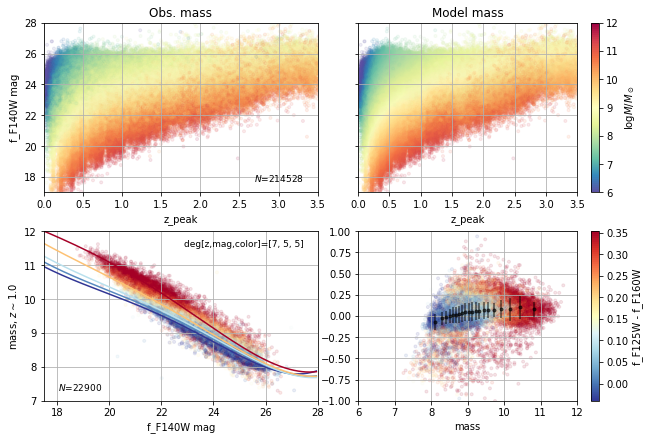

In [11]:
# Train on UltraVISTA ground-based catalog, huge area better sampling 
# at high masses, though not as good at faint end

# Read catalogs
ucat = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_master_interp_HST.fits')
#uzout = ucat
#uzout['lmass'] = np.log10(ucat['mass'])
#ufout = ucat
#ufout['z_peak'] = ucat['z_phot']
uzout = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.zout')
ufout = Table(np.genfromtxt('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.fout'),names = ('0','1','2','3','4','5','lmass','7','8','9','10'))
zshow = 1.0

ucat['cat']='uvista'

uphot_bands = ['f_F125W', 'f_F160W']
umag_band = 'f_F140W'
dq = (ucat['contamination'] == 0) & (ucat['star'] == 0) & (ucat['nan_contam'] == 0)

degree = [7,5,5]

# Use Ridge regressor to constrain high-order parameters and improve
# extrapolation
ridge_alpha = 0.01
clf = linear_model.Ridge(alpha=ridge_alpha)
out = empirical_mass2(ucat, uzout, ufout, mag_band=umag_band, mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=dq, root='uvista')

## Train on UltraVISTA + 3D-HST

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in maximum
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.104376e-23
  overwrite_a=True).T
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partit

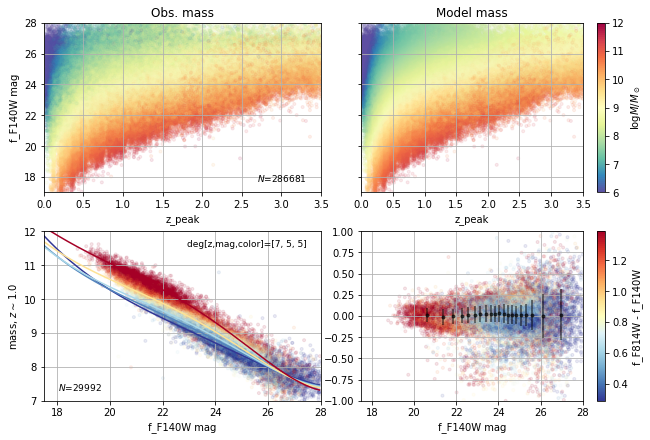

In [8]:
# Train on UltraVISTA ground-based catalog, huge area better sampling 
# at high masses, though not as good at faint end

# Read catalogs
pre_ucat = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_master_interp_HST.fits')
pre_ucat['cat'] = 'uvista'
#dq = (pre_ucat['contamination'] == 0) & (pre_ucat['star'] == 0) & (pre_ucat['nan_contam'] == 0)
uzout = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.zout')
ufout = Table(np.genfromtxt('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.fout'),names = ('0','1','2','3','4','5','lmass','7','8','9','10'))

#uzout = pre_ucat
#ufout = pre_ucat
#ufout['lmass'] = np.log10(pre_ucat['mass'])
#uzout['z_peak'] = uzout['z_phot']
#ucat = vstack([cat,pre_ucat[dq]])
#uzout = vstack([zout,uzout[dq]])
#ufout = vstack([fout,ufout[dq]])
ucat = vstack([cat,pre_ucat])
uzout = vstack([zout,uzout])
ufout = vstack([fout,ufout])

#uzout = utils.read_catalog('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.zout')
#ufout = Table(np.genfromtxt('../tables/UVISTA_DR3/UVISTA_DR3_master_v3.1.fout'),names = ('0','1','2','3','4','5','lmass','7','8','9','10'))

uphot_bands = ['f_F814W', 'f_F140W']
umag_band = 'f_F140W'
zshow = 1.

degree = [7,5,5]

# Use Ridge regressor to constrain high-order parameters and improve
# extrapolation
ridge_alpha = 0.01
clf = linear_model.Ridge(alpha=ridge_alpha)

out = empirical_mass(ucat, uzout, ufout, mag_band=umag_band, mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='uvista+3dhst')


# Test UltraVISTA model on 3D-HST

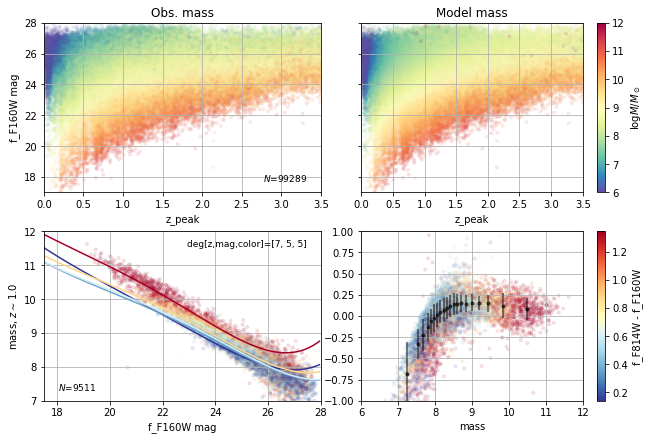

In [51]:
uvista_fit = np.load('../models/uvista_mass_f_F160W_f_F814W-f_F160W_d755_z1.0.npy')
phot_bands = ['f_F814W', 'f_F160W']
mag_band = 'f_F160W'


mag_ZP=25
root='predict-3dhst'
static_fit=uvista_fit
dq = None
xx = empirical_mass2(cat, zout, fout, mag_band=mag_band, mag_ZP=25, phot_bands=phot_bands, degree=degree, clf=clf, zshow=zshow, root='predict-3dhst', static_fit=uvista_fit)


# Create model

In [4]:
def empirical_mass(cat, zout, fout, root='3dhst', mag_band='F140W', mag_ZP=25, phot_bands=['F125W', 'F160W'], degree=[5,5,5], clf=None, zshow=1., dq=None, static_fit=None):
    """
    Get empirical mass as function of z, mag, color from 3D-HST catalogs

    mag_band: 'F140W'
        Band to use for the total magnitude

    phot_bands:  [str,str]
        Blue/red photometric bands from 3D-HST catalog to use for the
        discriminating color.

    degree: [int,int,int]
        Polynomial degree for [redshift, magnitude, color] fitting function.

    clf: `~sklearn.linear_model.LinearRegression`
        Regression model

    zshow: 1.
        Redshift to show the mass / mag relation

    dq: bool array, size of `cat`
        Extra DQ mask beyond default color/mass/star_flag
    """
    # Color
    blue = cat[phot_bands[0]]
    red = cat[phot_bands[1]]
    phot_color = -2.5*np.log10(np.maximum(np.maximum(blue, 1.e-6)/np.maximum(red, 1.e-6), 1e-6))

    # Magnitude
    hmag = mag_ZP - 2.5*np.log10(np.maximum(cat[mag_band], 1e-4))

    # Input data / output vector
    z = np.maximum(zout['z_peak'].data.data, 0)
    z[~np.isfinite(z)] = 0

    Xfull = np.vstack([np.log(1+z), hmag.data.data, phot_color.data.data]).T
    yobs = fout['lmass']
    # Transform data for polynomial model
    if static_fit is None:
        poly = PolynomialFeatures(np.max(degree))
    else:
        clf, poly, use_powers = static_fit

    X_ = poly.fit_transform(Xfull)

    # DQ selection: stars, etc.
    clip = (cat[mag_band] > 0) & (hmag < 28) & (phot_color < 10) & (phot_color > -10) & np.isfinite(fout['lmass']) & (blue > 0) & (red > 0) & (z > 0.02)

    if dq is not None:
        clip &= dq
    
    if ('star' in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (((cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)) | ((cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)))
    
    elif ('star' in cat.colnames) & ('star_flag' not in cat.colnames):
        clip &= (cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)
    
    elif ('star' not in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)
    
    #fix astropy masking BS
    clip = np.array(clip)
    
    
    ########################
    ### Limit polynomial degree by parameter
    powers = []
    for p in poly.get_feature_names():
        pdict = {}
        for k in p.split():
            if k.startswith('x'):
                i = int(k[1:].split('^')[0])
                if '^' in k:
                    power = int(k.split('^')[1])
                else:
                    power = 1

                pdict[i] = power

        p_i = []
        for i in range(poly.n_input_features_):
            if i in pdict:
                p_i.append(pdict[i])
            else:
                p_i.append(0)

        powers.append(p_i)
        #print(p, p_i)

    if static_fit is None:
        for i in range(poly.n_input_features_):
            if i == 0:
                use_powers = np.array(powers)[:,i] <= degree[i]
            else:
                use_powers &= np.array(powers)[:,i] <= degree[i]

    ######################
    ### Fit the Polynomial model        
    if static_fit is None:
        if clf is None:
            clf = linear_model.LinearRegression()

        clf.fit(X_[clip,:][:,use_powers], yobs[clip])

    y_pred = clf.predict(X_[:,use_powers])
    #######################
    ### Make a figure

    fig = plt.figure(figsize=[9,6])
    # Mass as function of mag / z
    ax = fig.add_subplot(221)
    ax.scatter(zout['z_peak'][clip], hmag[clip], c=yobs[clip], alpha=0.1, cmap=plt.cm.Spectral_r, vmin=6, vmax=12, marker='.')
    ax.set_title('Obs. mass')
    ax.text(0.95, 0.05, r'$N$={0}'.format(clip.sum()), ha='right', va='bottom', transform=ax.transAxes, size=9)
    
    # model mass as function of mag / z
    ax = fig.add_subplot(222)
    ax.scatter(zout['z_peak'][clip], hmag[clip], c=y_pred[clip], alpha=0.1, cmap=plt.cm.Spectral_r, vmin=6, vmax=12, marker='.')
    sc = ax.scatter(-10, -10, c=y_pred[clip][0], alpha=0.9, cmap=plt.cm.Spectral_r, vmin=6, vmax=12, marker='.')
    cb = plt.colorbar(sc)
    cb.set_label(r'$\log M/M_\odot$')

    ax.set_title('Model mass')

    for i, ax in enumerate(fig.axes[:2]):
        ax.set_xlim(0, 3.5)
        ax.set_ylim(17,28)
        if i > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(mag_band + ' mag')

        ax.set_xlabel('z_peak')
        ax.grid()

    ################### 
    #### z ~ 1 relation
    #zshow = 1.
    sel = clip & (np.abs(zout['z_peak'] - zshow) < 0.1)

    ax = fig.add_subplot(223)
    ax.text(0.95, 0.95, 'deg[z,mag,color]={0}'.format(degree), ha='right', va='top', transform=ax.transAxes, size=9)

    ax.text(0.05, 0.05, r'$N$={0}'.format(sel.sum()), ha='left', va='bottom', transform=ax.transAxes, size=9)
    
    vm = np.percentile(phot_color[sel], [10, 90])
    cmap = plt.cm.RdYlBu_r
    ax.scatter(hmag[sel], fout['lmass'][sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Spline Model @ z=1
    for color_i in np.percentile(phot_color[sel], [5, 25, 50, 75, 95]):
        splx = np.arange(17,28,0.05)
        Xz = np.vstack([splx*0+np.log(1+zshow), splx, splx*0+color_i]).T
        Xz_ = poly.fit_transform(Xz)
        y_ = clf.predict(Xz_[:,use_powers])

        c_i = cmap(np.interp(color_i, vm, [0, 1], left=0, right=1))

        ax.plot(splx, y_, color=c_i)

    ax.set_xlim(17.5, 28)
    ax.set_ylim(7, 12); ax.set_ylabel(r'mass, $z\sim${0:.1f}'.format(zshow)); ax.set_xlabel(mag_band + ' mag')
    ax.grid()

    # Mass residuals
    ax = fig.add_subplot(224)
    ax.scatter(hmag[sel], (yobs - y_pred)[sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')
    sc = ax.scatter(-10, -10, c=phot_color[sel][0], alpha=0.9, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Running median + scatter
    # eazy = https://github.com/gbrammer/eazy-py
    xm, ym, ys, N = eazy.utils.running_median(hmag[sel], fout['lmass'][sel] - y_pred[sel], NBIN=20, use_median=True, use_nmad=True, reverse=False, bins=None)
    ax.errorbar(xm, ym, yerr=ys, color='k', marker='.', alpha=0.6, linestyle='None')

    cb = plt.colorbar(sc)
    cb.set_label('{0} - {1}'.format(phot_bands[0], phot_bands[1]))

    ax.set_xlim(17.5, 28)
    ax.set_ylim(-1, 1); ax.set_xlabel(mag_band + ' mag')
    ax.grid()

    fig.tight_layout(pad=0.3)
    label = '{0}_{1}-{2}_d{3}_z{4:.1f}'.format(mag_band, phot_bands[0], phot_bands[1], ''.join(['{0}'.format(i) for i in degree]), zshow)

    fig.savefig('../figures/'+root+'_mass_{0}.png'.format(label))
    np.save('../scratch/'+root+'_mass_{0}.npy'.format(label), [clf, poly, use_powers])
    
    return fig, label, [clf, poly, use_powers]

In [4]:
def empirical_mass2(cat, zout, fout, root='3dhst', mag_band='F140W', mag_ZP=23.9, phot_bands=['F125W', 'F160W'], degree=[5,5,5], clf=None, zshow=1., dq=None, static_fit=None):
    """
    Get empirical mass as function of z, mag, color from 3D-HST catalogs

    mag_band: 'F140W'
        Band to use for the total magnitude

    phot_bands:  [str,str]
        Blue/red photometric bands from 3D-HST catalog to use for the
        discriminating color.

    degree: [int,int,int]
        Polynomial degree for [redshift, magnitude, color] fitting function.

    clf: `~sklearn.linear_model.LinearRegression`
        Regression model

    zshow: 1.
        Redshift to show the mass / mag relation

    dq: bool array, size of `cat`
        Extra DQ mask beyond default color/mass/star_flag
    """
    # Color
    blue = cat[phot_bands[0]]
    red = cat[phot_bands[1]]
    phot_color = -2.5*np.log10(np.maximum(np.maximum(blue, 1.e-6)/np.maximum(red, 1.e-6), 1e-6))

    # Magnitude
    hmag = mag_ZP - 2.5*np.log10(np.maximum(cat[mag_band], 1e-4))

    # Input data / output vector
    z = np.maximum(zout['z_peak'].data.data, 0)
    z[~np.isfinite(z)] = 0

    Xfull = np.vstack([np.log(1+z), hmag.data.data, phot_color.data.data]).T
    yobs = fout['lmass']
    # Transform data for polynomial model
    if static_fit is None:
        poly = PolynomialFeatures(np.max(degree))
    else:
        clf, poly, use_powers = static_fit

    X_ = poly.fit_transform(Xfull)

    # DQ selection: stars, etc.
    clip = (cat[mag_band] > 0) & (hmag < 28) & (phot_color < 10) & (phot_color > -10) & np.isfinite(fout['lmass']) & (blue > 0) & (red > 0) & (z > 0.02)

    if dq is not None:
        clip &= dq
    
    if ('star' in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (((cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)) | ((cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)))
    
    elif ('star' in cat.colnames) & ('star_flag' not in cat.colnames):
        clip &= (cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)
    
    elif ('star' not in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)
        clip &= hmag < 24
        clip &= (z>0.6) & (z<1.6)
    
    #fix astropy masking BS
    clip = np.array(clip)
    
    
    ########################
    ### Limit polynomial degree by parameter
    powers = []
    for p in poly.get_feature_names():
        pdict = {}
        for k in p.split():
            if k.startswith('x'):
                i = int(k[1:].split('^')[0])
                if '^' in k:
                    power = int(k.split('^')[1])
                else:
                    power = 1

                pdict[i] = power

        p_i = []
        for i in range(poly.n_input_features_):
            if i in pdict:
                p_i.append(pdict[i])
            else:
                p_i.append(0)

        powers.append(p_i)
        #print(p, p_i)

    if static_fit is None:
        for i in range(poly.n_input_features_):
            if i == 0:
                use_powers = np.array(powers)[:,i] <= degree[i]
            else:
                use_powers &= np.array(powers)[:,i] <= degree[i]

    ######################
    ### Fit the Polynomial model        
    if static_fit is None:
        if clf is None:
            clf = linear_model.LinearRegression()

        clf.fit(X_[clip,:][:,use_powers], yobs[clip])

    y_pred = clf.predict(X_[:,use_powers])
    #######################
    ### Make a figure

    fig = plt.figure(figsize=[9,6])
    # Mass as function of mag / z
    ax = fig.add_subplot(221)
    ax.scatter(zout['z_peak'][clip], hmag[clip], c=yobs[clip], alpha=0.1, cmap=plt.cm.Spectral_r, vmin=6, vmax=12, marker='.')
    ax.set_title('Obs. mass')
    ax.text(0.95, 0.05, r'$N$={0}'.format(clip.sum()), ha='right', va='bottom', transform=ax.transAxes, size=9)
    
    # model mass as function of mag / z
    ax = fig.add_subplot(222)
    ax.scatter(zout['z_peak'][clip], hmag[clip], c=y_pred[clip], alpha=0.1, cmap=plt.cm.Spectral_r, vmin=6, vmax=12, marker='.')
    sc = ax.scatter(-10, -10, c=y_pred[clip][0], alpha=0.9, cmap=plt.cm.Spectral_r, vmin=6, vmax=12, marker='.')
    cb = plt.colorbar(sc)
    cb.set_label(r'$\log M/M_\odot$')

    ax.set_title('Model mass')

    for i, ax in enumerate(fig.axes[:2]):
        ax.set_xlim(0, 3.5)
        ax.set_ylim(17,28)
        if i > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(mag_band + ' mag')

        ax.set_xlabel('z_peak')
        ax.grid()

    ################### 
    #### z ~ 1 relation
    #zshow = 1.
    sel = clip & (np.abs(zout['z_peak'] - zshow) < 0.1)

    ax = fig.add_subplot(223)
    ax.text(0.95, 0.95, 'deg[z,mag,color]={0}'.format(degree), ha='right', va='top', transform=ax.transAxes, size=9)

    ax.text(0.05, 0.05, r'$N$={0}'.format(sel.sum()), ha='left', va='bottom', transform=ax.transAxes, size=9)
    
    vm = np.percentile(phot_color[sel], [10, 90])
    cmap = plt.cm.RdYlBu_r
    ax.scatter(hmag[sel], fout['lmass'][sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Spline Model @ z=1
    for color_i in np.percentile(phot_color[sel], [5, 25, 50, 75, 95]):
        splx = np.arange(17,28,0.05)
        Xz = np.vstack([splx*0+np.log(1+zshow), splx, splx*0+color_i]).T
        Xz_ = poly.fit_transform(Xz)
        y_ = clf.predict(Xz_[:,use_powers])

        c_i = cmap(np.interp(color_i, vm, [0, 1], left=0, right=1))

        ax.plot(splx, y_, color=c_i)

    ax.set_xlim(17.5, 28)
    ax.set_ylim(7, 12); ax.set_ylabel(r'mass, $z\sim${0:.1f}'.format(zshow)); ax.set_xlabel(mag_band + ' mag')
    ax.grid()

    # Mass residuals
    ax = fig.add_subplot(224)
    ax.scatter(fout['lmass'][sel], (yobs - y_pred)[sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')
    sc = ax.scatter(-10, -10, c=phot_color[sel][0], alpha=0.9, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Running median + scatter
    # eazy = https://github.com/gbrammer/eazy-py
    xm, ym, ys, N = eazy.utils.running_median(fout['lmass'][sel], fout['lmass'][sel] - y_pred[sel], NBIN=20, use_median=True, use_nmad=True, reverse=False, bins=None)
    ax.errorbar(xm, ym, yerr=ys, color='k', marker='.', alpha=0.6, linestyle='None')

    cb = plt.colorbar(sc)
    cb.set_label('{0} - {1}'.format(phot_bands[0], phot_bands[1]))

    ax.set_xlim(6, 12)
    ax.set_ylim(-1, 1); ax.set_xlabel('mass')
    ax.grid()

    fig.tight_layout(pad=0.3)
    label = '{0}_{1}-{2}_d{3}_z{4:.1f}'.format(mag_band, phot_bands[0], phot_bands[1], ''.join(['{0}'.format(i) for i in degree]), zshow)

    fig.savefig('../figures/'+root+'_mass_{0}.png'.format(label))
    np.save('../model_uvista_interp/'+root+'_mass_{0}.npy'.format(label), [clf, poly, use_powers])
    print('../figures/'+root+'_mass_{0}.png'.format(label))
    print('../model_uvista_interp/'+root+'_mass_{0}.npy'.format(label))
    return fig, label, [clf, poly, use_powers]

In [ ]:
im = 